In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, RocCurveDisplay, confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, make_scorer, fbeta_score,accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from time import time
from sklearn.linear_model import RidgeCV
import scikitplot as skplt
import plotly.express as px
import folium
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier , plot_tree
# import eli5 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.decomposition import TruncatedSVD
import warnings

random_state=42

In [3]:
data_df = pd.read_csv("hotel_bookings.csv")
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.options.display.max_rows = 200000
data_df = data_df.drop(columns=["reservation_status_date", "hotel", "reservation_status",
    "arrival_date_week_number", "reserved_room_type", "company"])

data_df["total_guests"] = data_df["adults"] + data_df["children"] + data_df["babies"]
data_df["price_per_guest"] = data_df["adr"]/data_df["total_guests"]

filter = (data_df.children == 0) & (data_df.adults == 0) & (data_df.babies == 0)
data_df[filter]
data_df = data_df[~filter]
data_df=data_df.replace(" ","_")
data_df = data_df.reindex(data_df.columns.tolist(), axis = 1)

In [4]:
nan_replacements = {"children": 0.0, "agent": 0, "country": "unknown", "total_guests":0, "price_per_guest":0}
data_df = data_df.fillna(nan_replacements)

In [5]:
# czy usunąć też: data_df["price_per_guest"] ==0???

data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
data_df.dropna(inplace=True)

data_df.drop(14969)
data_df.shape

(119210, 28)

In [6]:
features = data_df.drop(columns=["is_canceled","total_guests"], axis=1).columns
# features

In [7]:
x = data_df[features]
y = data_df["is_canceled"]


In [20]:
x = pd.get_dummies(x, drop_first=True)
# x.head()

In [21]:
models = [("Dummy_Model:",DummyClassifier(strategy="stratified")),
            ("DecisionTree_Model", DecisionTreeClassifier(random_state=42)),
            ("RandomForest_Model", RandomForestClassifier(random_state=42)),
            ("LogisticRegression_Model", LogisticRegression(random_state=42, solver="liblinear")),
            ("XGBBoost_Model", XGBClassifier(random_state=42,use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1)),
            ("Gaussian_Model", GaussianNB()),
            ("KNN_Model", KNeighborsClassifier())]

split = KFold(n_splits=4, shuffle=True, random_state=42)
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

In [9]:
# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in models:
    start = time()
    cv_results = cross_val_score(model, x, y, cv=split, scoring="accuracy")
    fbeta_res = cross_val_score(model, x, y, cv=split, scoring=fbeta_scorer)
    mean_score = round(np.mean(cv_results), 4)
    fbeta_score = round(np.mean(fbeta_res), 4)
    end = time()
    cross_val_time = round(end-start,4)
    print(f"{name}  f-beta: {fbeta_score}, accuracy score: {mean_score}, time: {cross_val_time}")

Dummy_Model:  f-beta: 0.3734, accuracy score: 0.5334, time: 0.8999
DecisionTree_Model  f-beta: 0.8079, accuracy score: 0.8583, time: 14.0053
RandomForest_Model  f-beta: 0.873, accuracy score: 0.8917, time: 146.236
LogisticRegression_Model  f-beta: 0.7727, accuracy score: 0.8134, time: 11.9565
XGBBoost_Model  f-beta: 0.8436, accuracy score: 0.8766, time: 97.6077
Gaussian_Model  f-beta: 0.4862, accuracy score: 0.5256, time: 4.4313
KNN_Model  f-beta: 0.6996, accuracy score: 0.7739, time: 101.8473


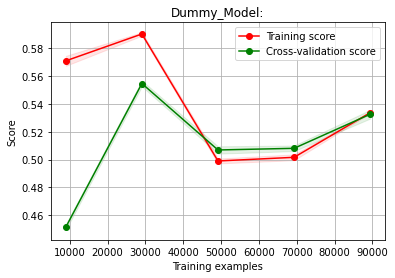

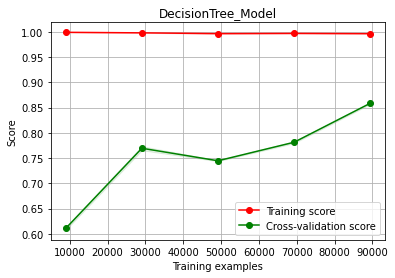

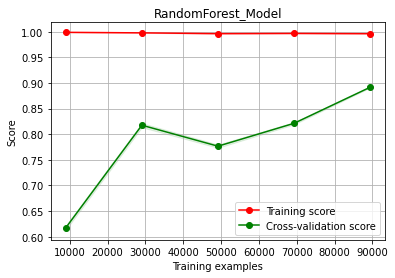

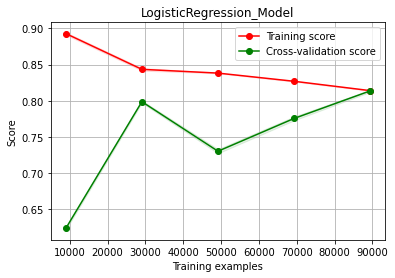

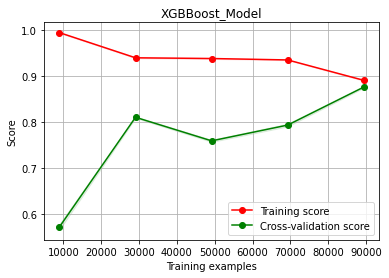

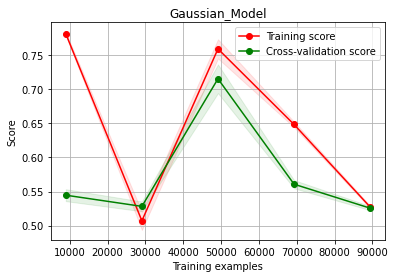

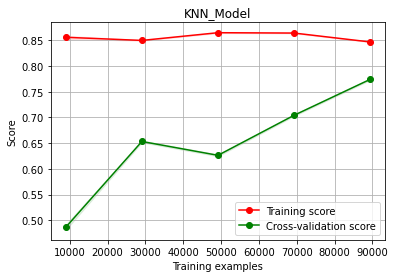

In [14]:
for name, model in models:
    skplt.estimators.plot_learning_curve(model, x, y,name, cv=split)
    plt.show()

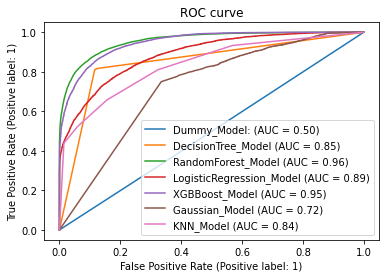

In [15]:
warnings.filterwarnings("ignore")

split = KFold(n_splits=4, shuffle=True, random_state=42)

x1 = np.array(x)
y1= np.array(y)

fig, ax = plt.subplots()

for name, model in models:
    for i, (train, test) in enumerate(split.split(x1)):
        if i == 3:
            x1_train, x1_test = x1[train], x1[test]
            y1_train, y1_test = y1[train], y1[test]
            fit = model.fit(x1[train], y1[train])
            plot_roc_curve(model, x1_test, y1_test, ax=ax, name=name)
_ = ax.set_title("ROC curve")

In [22]:
x1 = np.array(x)
y1= np.array(y)

for name, model in models:
    for i, (train, test) in enumerate(split.split(x1)):
        if i == 3:
            x1_train, x1_test = x1[train], x1[test]
            y1_train, y1_test = y1[train], y1[test]
            fit = model.fit(x1[train], y1[train])
            y1_pred = model.predict(x1_test)
            print(f"{name}\n",confusion_matrix(y1_test, y1_pred))

Dummy_Model:
 [[11888  6980]
 [ 6821  4113]]
DecisionTree_Model
 [[16647  2221]
 [ 2061  8873]]
RandomForest_Model
 [[17760  1108]
 [ 2100  8834]]
LogisticRegression_Model
 [[17164  1704]
 [ 3914  7020]]
XGBBoost_Model
 [[17316  1552]
 [ 2190  8744]]
Gaussian_Model
 [[ 5350 13518]
 [  738 10196]]
KNN_Model
 [[15918  2950]
 [ 3742  7192]]


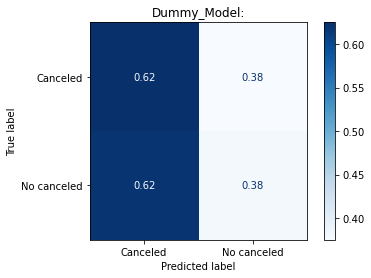

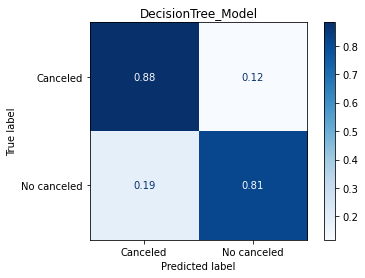

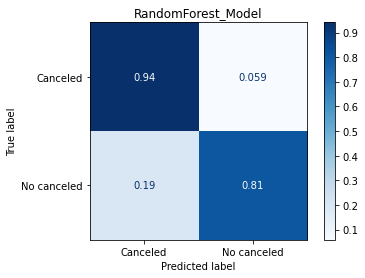

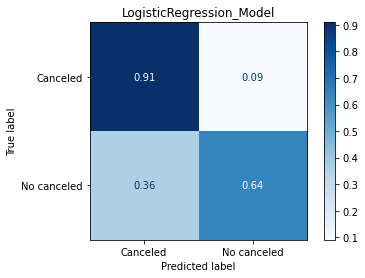

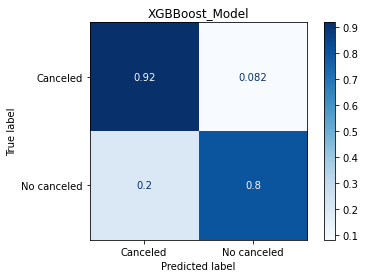

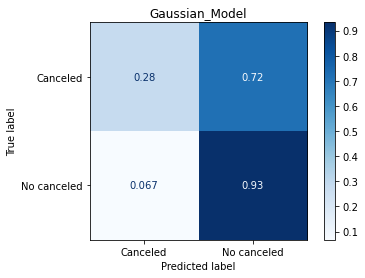

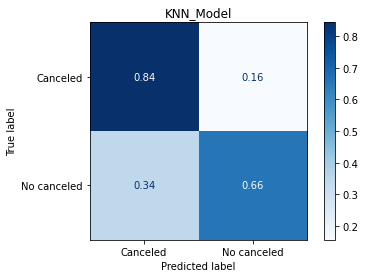

In [31]:
for name, model in models:
    plot_confusion_matrix(model, x1_test, y1_test,display_labels=['Canceled','No canceled'],cmap=plt.cm.Blues, normalize="true")
    plt.title(f"{name}")
    plt.show()